# <center> WASC calibration </center>

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-whitegrid")
from matplotlib.pyplot import figure
from importlib import reload
import sys
import src.Wishart.WASC
reload(src.Wishart.WASC)
from src.Wishart.WASC import calibrate_wasc, ModelParameters
from src.utils import process_data, round_params
import datetime
import warnings
warnings.filterwarnings("ignore")
import h5py
import matplotlib.dates as mdates
from tqdm.notebook import tqdm

In [2]:
%%time
raw = pd.HDFStore('datasets/eth-20230224.h5','r').get("/eth")
# raw2 = pd.HDFStore('../datasets/eth-20230127.h5','r').get("/eth")
# raw3 = pd.HDFStore('../datasets/eth-20230310.h5','r').get("/eth")
# raw = pd.concat([raw1, raw2, raw3]).drop_duplicates()
# raw.dt.hist(bins = 100)

CPU times: user 21.2 s, sys: 2.82 s, total: 24.1 s
Wall time: 25.6 s


In [3]:
%%time
df = process_data(raw)
df.head()

CPU times: user 48.9 s, sys: 14.5 s, total: 1min 3s
Wall time: 1min 11s


,dt,mark_price,instrument,type,strike_price,expiration,underlying_price,timestamp
0,2022-11-21 13:08:24.511,0.0005,ETH-25NOV22-1700-C,call,1700,1669334400000000,1133.9,1669036104511000
1,2022-11-21 13:08:24.511,0.0005,ETH-25NOV22-2400-C,call,2400,1669334400000000,1133.9,1669036104511000
2,2022-11-21 13:08:24.511,0.0020,ETH-25NOV22-700-P,put,700,1669334400000000,1133.9,1669036104511000
3,2022-11-21 13:08:24.511,0.0005,ETH-25NOV22-3800-C,call,3800,1669334400000000,1133.9,1669036104511000
4,2022-11-21 13:08:24.511,0.0005,ETH-25NOV22-3400-C,call,3400,1669334400000000,1133.9,1669036104511000


# Params dynamics

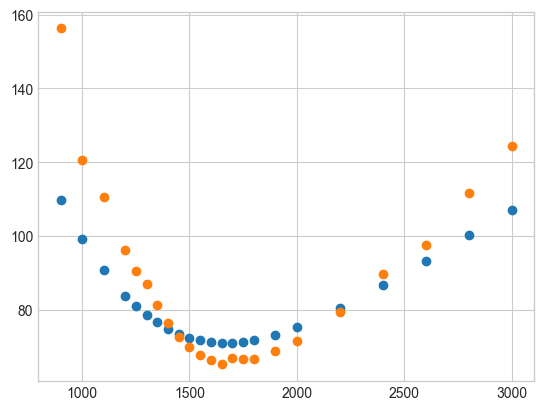

In [45]:
plt.scatter(first_res["strike_price"], first_res["calibrated_iv"])
plt.scatter(first_res["strike_price"], first_res["iv"])

In [58]:
calibrated_params_all

array([ 0.43038142,  0.79774923,  0.07737781,  0.34487682,  0.17218977,
       -0.3076329 ,  0.13543856, -0.89499041, -3.91552141, -0.46881025,
       -1.37374317])

In [60]:
%%time
number_of_dots = 50
timestamps_hm = []

params_all = []
errors_all = []

Q11, Q12, Q21, Q22, E11, Ed, E22, R11, R12, R21, R22 = 0.3417, 0.3493, 0.1848, 0.3090, 0.0298, 0.0119, 0.0108, -1.2479, -0.8985, -0.0820, -1.1433
start_params = np.array([Q11, Q12, Q21, Q22, E11, Ed, E22, R11, R12, R21, R22])

# Get ticks with similar distnce from available data
calibr_borders = df[(df["dt"] >= "2023-02-04") & (df["dt"] <= "2023-02-04 23:00:00")].copy()
df_only_exp = calibr_borders[calibr_borders["expiration"] == calibr_borders.sample(1).expiration.iloc[0]].copy()

print("Optimize first params with random start once")
calibrated_params_all, first_error_all, first_res  = calibrate_wasc(df = df_only_exp, 
                                                        start_params = start_params)


print("All first calibrated:", round_params(calibrated_params_all), "error:", first_error_all)
timestamps = np.linspace(calibr_borders.timestamp.min(), calibr_borders.timestamp.max(), number_of_dots)
for timestamp in tqdm(timestamps):
    try:
        # zero params for each point are params from last step
        calibrated_params_all, error_all, _  = calibrate_wasc(df = df_only_exp, start_params = calibrated_params_all, 
                                    timestamp = timestamp)
        print("All calibrated:", round_params(calibrated_params_all), "error:", error_all)


        params_all.append(calibrated_params_all)
        errors_all.append(error_all)
        timestamps_hm.append(timestamp)
    except:
        print("Error!")
        calibrated_params_all = start_params
        
        
        print("    ")

timestamps_hm = [datetime.datetime.fromtimestamp(x/1000000.0) for x in timestamps_hm]
params_all = np.array(params_all).T





Optimize first params with random start once
All first calibrated: [0.428, 0.801, 0.077, 0.347, 0.174, -0.308, 0.137, -0.894, -3.937, -0.47, -1.382] error: 0.02754381730869356


  0%|          | 0/50 [00:00<?, ?it/s]

Error!
    
All calibrated: [0.408, 0.97, 0.065, 0.383, 0.16, -0.229, 0.087, -0.794, -6.28, -0.482, -1.642] error: 0.01550875026567061
All calibrated: [0.408, 0.97, 0.065, 0.383, 0.16, -0.229, 0.087, -0.794, -6.28, -0.482, -1.642] error: 0.01562177846824906
Error!
    
All calibrated: [0.392, 0.955, 0.065, 0.382, 0.164, -0.232, 0.093, -0.767, -6.555, -0.459, -1.677] error: 0.010808197925753915
Error!
    
All calibrated: [0.403, 0.943, 0.067, 0.38, 0.167, -0.236, 0.098, -0.784, -6.168, -0.466, -1.641] error: 0.012664957497044589
All calibrated: [0.403, 0.943, 0.067, 0.38, 0.167, -0.236, 0.098, -0.784, -6.168, -0.466, -1.641] error: 0.011634741200341938
Error!
    
All calibrated: [0.289, 0.983, 0.067, 0.357, 0.201, -0.231, 0.119, -0.628, -6.056, -0.243, -1.828] error: 0.011900483481087465
All calibrated: [0.289, 0.983, 0.067, 0.357, 0.201, -0.231, 0.119, -0.628, -6.055, -0.243, -1.828] error: 0.012180490218581056
All calibrated: [0.288, 0.982, 0.067, 0.357, 0.201, -0.232, 0.12, -0.628,

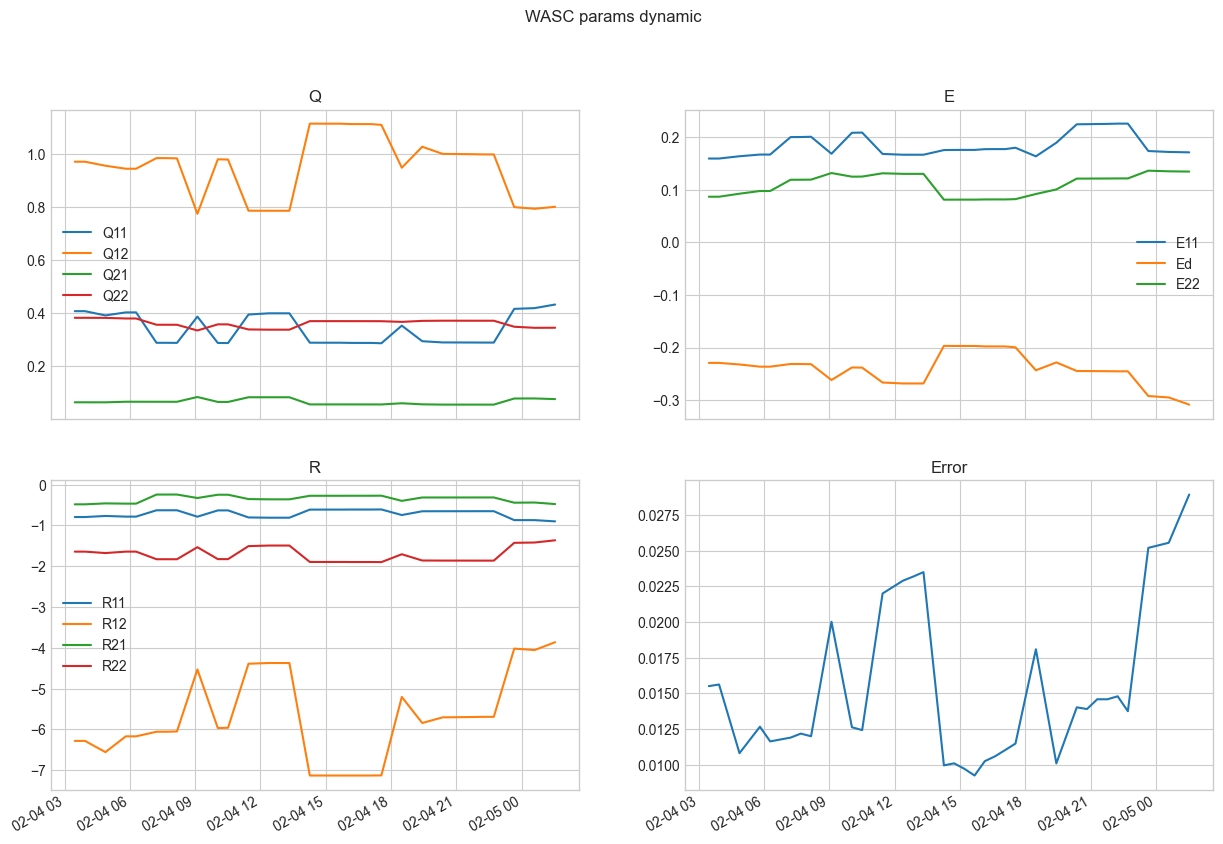

In [89]:
fig, axs =  plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

axs[0, 0].plot(timestamps_hm, params_all[0], label = "Q11")
axs[0, 0].plot(timestamps_hm, params_all[1], label = "Q12")
axs[0, 0].plot(timestamps_hm, params_all[2], label = "Q21")
axs[0, 0].plot(timestamps_hm, params_all[3], label = "Q22")
axs[0, 0].legend()

axs[0, 1].plot(timestamps_hm, params_all[4], label = "E11")
axs[0, 1].plot(timestamps_hm, params_all[5], label = "Ed")
axs[0, 1].plot(timestamps_hm, params_all[6], label = "E22")
axs[0, 1].legend()

axs[1, 0].plot(timestamps_hm, params_all[7], label = "R11")
axs[1, 0].plot(timestamps_hm, params_all[8], label = "R12")
axs[1, 0].plot(timestamps_hm, params_all[9], label = "R21")
axs[1, 0].plot(timestamps_hm, params_all[10], label = "R22")
axs[1, 0].legend()

axs[1, 1].plot(timestamps_hm, errors_all, label = "R22")


axs[0, 0].set_title(r"Q")
axs[0, 1].set_title(r"E")
axs[1, 0].set_title(r"R")
axs[1, 1].set_title(r"Error")



# plt.figlegend() 
fig.suptitle("WASC params dynamic")
plt.gcf().autofmt_xdate()
plt.show()

# Volatility smile

In [80]:
df_only_exp = df[df["expiration"] == df.sample(1).expiration.iloc[0]].copy()
needed_stamp = df_only_exp.sample(1).iloc[0].timestamp

In [81]:
Q11, Q12, Q21, Q22, E11, Ed, E22, R11, R12, R21, R22 = 0.3417, 0.3493, 0.1848, 0.3090, 0.0298, 0.0119, 0.0108, -1.2479, -0.8985, -0.0820, -1.1433
start_params = np.array([Q11, Q12, Q21, Q22, E11, Ed, E22, R11, R12, R21, R22])

pars_all, err_all, C_all = calibrate_wasc(df = df_only_exp, 
                                          start_params = start_params, 
                                          timestamp = needed_stamp,)



print("All:")
print(round_params(pars_all))
print(err_all)
print("   ")



All:
[0.199, 0.822, 0.078, 0.311, 0.132, -0.172, 0.071, -0.479, -6.13, -0.046, -2.099]
0.01582678215917514
   


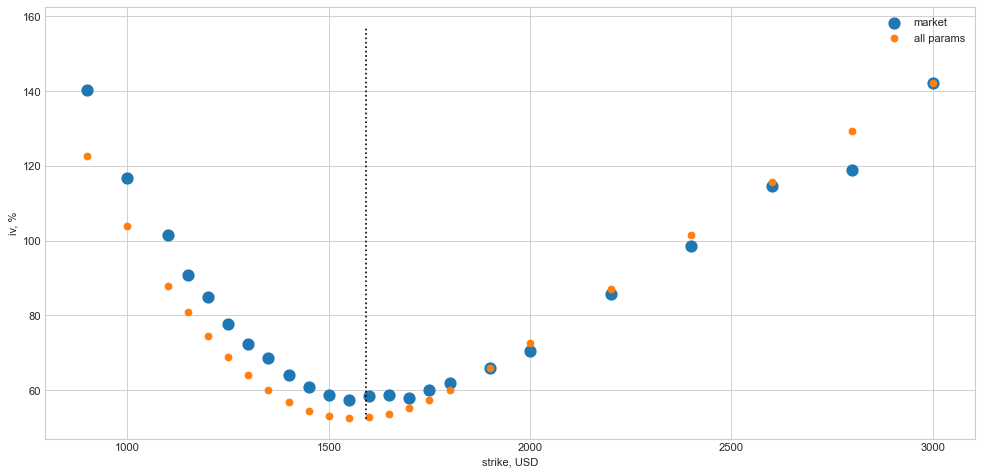

In [82]:
figure(figsize=(15, 7), dpi=80)

plt.scatter(C_all["strike_price"], C_all["iv"], label = "market", linewidths = 5)

# bid,ask iv
# plt.plot(C_sing_exp_all["strike_price"], C_sing_exp_all["ask_iv"], '--', label = "ask_iv", color = "black")
# plt.plot(C_sing_exp_all["strike_price"], C_sing_exp_all["bid_iv"], '--', label = "bid_iv", color = "yellow")

plt.scatter(C_all["strike_price"], C_all["calibrated_iv"], label = "all params")
# plt.scatter(C_beta["strike_price"], C_beta["calibrated_iv"], label = r"$\beta$")


plt.vlines([C_all.underlying_price.mean()], C_all.iv.min() - 5, 
           C_all.iv.max() + 15, color = "black", linestyles = "dotted")

plt.xlabel("strike, USD")
plt.ylabel("iv, %")
plt.legend()
plt.show()